In [1]:
import sys
sys.path.append('..')

from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from itertools import islice
from tqdm import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

d:\My Works\Coding\EV_Translate_Modle_NLP_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load PHOMT Dataset

In [2]:
# Load PHOMT dataset from local files
print("Loading PHOMT dataset from local files...")
print("Filtering sentences with length <= 128 tokens...")

# Paths to local PhoMT files
train_en_path = r"../data/raw/PhoMT/PhoMT/tokenization/train/train.en"
train_vi_path = r"../data/raw/PhoMT/PhoMT/tokenization/train/train.vi"

# Filter function
def filter_by_length(vi_text, en_text):
    vi_len = len(vi_text.split())
    en_len = len(en_text.split())
    return vi_len <= 128 and en_len <= 128 and vi_len >= 3 and en_len >= 3

# Read files line by line with filter
# Load 350K samples (will split later in preprocessing notebook)
print("Reading and filtering data...")
vi_sentences = []
en_sentences = []
count = 0
target_count = 350000

with open(train_vi_path, 'r', encoding='utf-8') as f_vi, \
     open(train_en_path, 'r', encoding='utf-8') as f_en:
    
    for vi_line, en_line in tqdm(zip(f_vi, f_en), desc="Loading samples"):
        vi_text = vi_line.strip()
        en_text = en_line.strip()
        
        if filter_by_length(vi_text, en_text):
            vi_sentences.append(vi_text)
            en_sentences.append(en_text)
            count += 1
            
            if count >= target_count:
                break

print(f"\nCollected {len(vi_sentences)} sentence pairs")

# Convert to dataset format
from datasets import Dataset
dataset = Dataset.from_dict({
    'vi': vi_sentences,
    'en': en_sentences
})

print(f"\nDataset size: {len(dataset)}")
print(f"\nDataset features: {dataset.features}")
print(f"\nFirst example:")
print(f"VI: {dataset[0]['vi']}")
print(f"EN: {dataset[0]['en']}")
print(f"\nLast example:")
print(f"VI: {dataset[-1]['vi']}")
print(f"EN: {dataset[-1]['en']}")

Loading PHOMT dataset from local files...
Filtering sentences with length <= 128 tokens...
Reading and filtering data...


Loading samples: 350208it [00:01, 285569.80it/s]



Collected 350000 sentence pairs

Dataset size: 350000

Dataset features: {'vi': Value('string'), 'en': Value('string')}

First example:
VI: Câu chuyện bắt đầu với buổi lễ đếm ngược .
EN: It begins with a countdown .

Last example:
VI: Ví dụ như , khi người kia đang la hét với bạn , bạn có thể nói những câu như : ' Tôi muốn giúp anh , nhưng tôi không hiểu anh đang nói gì vì anh nói to quá .
EN: For example , if the other person is shouting at you , you could say something like this : " I want to help you , but I can not understand what you 're saying when you speak so loudly .


## 2. Basic Statistics

In [3]:
# Calculate basic statistics
print("=" * 60)
print("BASIC STATISTICS")
print("=" * 60)

# Count
total_pairs = len(dataset)
print(f"\nTotal sentence pairs: {total_pairs:,}")

# Calculate lengths
vi_lengths = [len(sent.split()) for sent in dataset['vi']]
en_lengths = [len(sent.split()) for sent in dataset['en']]

# Vietnamese statistics
print(f"\n{'Vietnamese:':<20}")
print(f"  Average length:    {np.mean(vi_lengths):.2f} words")
print(f"  Min length:        {np.min(vi_lengths)} words")
print(f"  Max length:        {np.max(vi_lengths)} words")
print(f"  Std deviation:     {np.std(vi_lengths):.2f}")

# English statistics
print(f"\n{'English:':<20}")
print(f"  Average length:    {np.mean(en_lengths):.2f} words")
print(f"  Min length:        {np.min(en_lengths)} words")
print(f"  Max length:        {np.max(en_lengths)} words")
print(f"  Std deviation:     {np.std(en_lengths):.2f}")

# Length ratio
avg_ratio = np.mean([v/e for v, e in zip(vi_lengths, en_lengths)])
print(f"\nAverage VI/EN length ratio: {avg_ratio:.2f}")

BASIC STATISTICS

Total sentence pairs: 350,000

Vietnamese:         
  Average length:    23.55 words
  Min length:        3 words
  Max length:        128 words
  Std deviation:     15.32

English:            
  Average length:    19.64 words
  Min length:        3 words
  Max length:        126 words
  Std deviation:     12.66

Average VI/EN length ratio: 1.22


## 3. Token Length Analysis

LENGTH DISTRIBUTION ANALYSIS

Percentile      Vietnamese      English        
---------------------------------------------
50th             20.0            17.0           
75th             31.0            26.0           
90th             43.0            36.0           
95th             53.0            44.0           
99th             76.0            63.0           


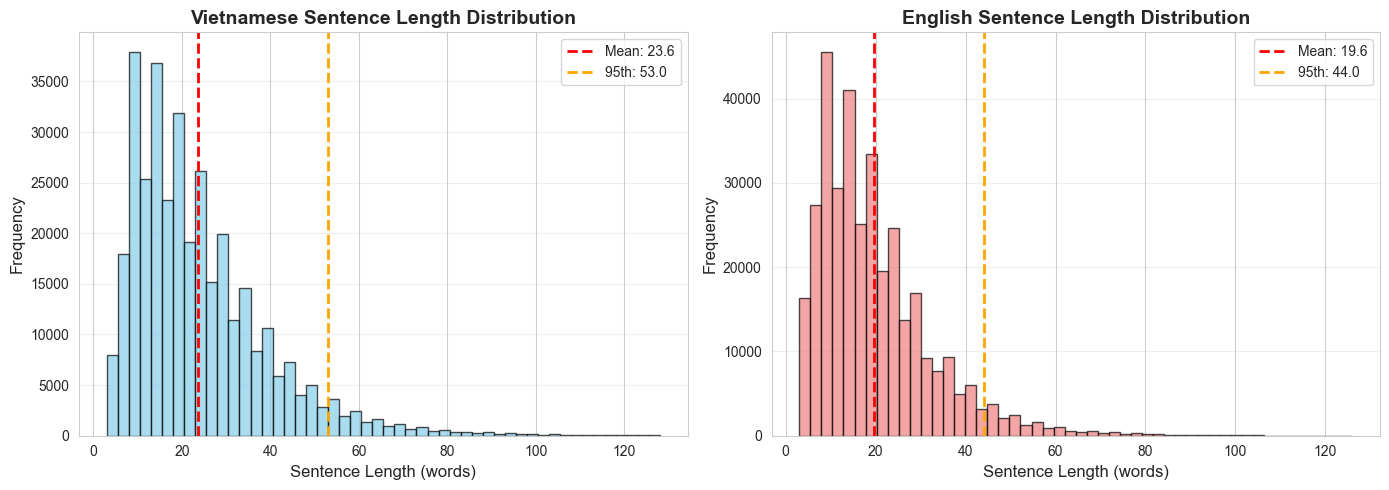


✅ Max length of 128 covers 100.00% of Vietnamese sentences
✅ Max length of 128 covers 100.00% of English sentences


In [4]:
# Analyze length distribution
print("=" * 60)
print("LENGTH DISTRIBUTION ANALYSIS")
print("=" * 60)

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99]
print(f"\n{'Percentile':<15} {'Vietnamese':<15} {'English':<15}")
print("-" * 45)
for p in percentiles:
    vi_p = np.percentile(vi_lengths, p)
    en_p = np.percentile(en_lengths, p)
    print(f"{p}th{'':<12} {vi_p:<15.1f} {en_p:<15.1f}")

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vietnamese histogram
axes[0].hist(vi_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(vi_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(vi_lengths):.1f}')
axes[0].axvline(np.percentile(vi_lengths, 95), color='orange', linestyle='--', linewidth=2, label=f'95th: {np.percentile(vi_lengths, 95):.1f}')
axes[0].set_xlabel('Sentence Length (words)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Vietnamese Sentence Length Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# English histogram
axes[1].hist(en_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(en_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(en_lengths):.1f}')
axes[1].axvline(np.percentile(en_lengths, 95), color='orange', linestyle='--', linewidth=2, label=f'95th: {np.percentile(en_lengths, 95):.1f}')
axes[1].set_xlabel('Sentence Length (words)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('English Sentence Length Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Max length of 128 covers {(np.array(vi_lengths) <= 128).sum() / len(vi_lengths) * 100:.2f}% of Vietnamese sentences")
print(f"✅ Max length of 128 covers {(np.array(en_lengths) <= 128).sum() / len(en_lengths) * 100:.2f}% of English sentences")

## 4. Sample Data Visualization

In [5]:
# Show random sample translations
print("=" * 80)
print("SAMPLE TRANSLATIONS")
print("=" * 80)

# Select samples with different lengths
import random
random.seed(42)

# Get samples from different length buckets
short_indices = [i for i, l in enumerate(vi_lengths) if 3 <= l <= 10]
medium_indices = [i for i, l in enumerate(vi_lengths) if 20 <= l <= 40]
long_indices = [i for i, l in enumerate(vi_lengths) if 60 <= l <= 100]

sample_indices = (
    random.sample(short_indices, min(5, len(short_indices))) +
    random.sample(medium_indices, min(10, len(medium_indices))) +
    random.sample(long_indices, min(5, len(long_indices)))
)

for idx in sample_indices:
    vi_text = dataset[idx]['vi']
    en_text = dataset[idx]['en']
    print(f"\n[{idx}] ({len(vi_text.split())} words VI / {len(en_text.split())} words EN)")
    print(f"VI: {vi_text}")
    print(f"EN: {en_text}")
    print("-" * 80)

SAMPLE TRANSLATIONS

[209554] (8 words VI / 7 words EN)
VI: Có lẽ các bạn biết bà ấy .
EN: Maybe you 've heard of her .
--------------------------------------------------------------------------------

[36335] (8 words VI / 9 words EN)
VI: " Đây là một vũng nước . "
EN: " Here is a pool of water . "
--------------------------------------------------------------------------------

[8114] (10 words VI / 12 words EN)
VI: Tôi đã đi 4000 km trong vòng 12 năm .
EN: I 've walked about 4,000 kilometers in the last 12 years .
--------------------------------------------------------------------------------

[243071] (10 words VI / 10 words EN)
VI: Những gì họ đã làm là một cuộc xâm lược
EN: What they 'd have done then is an invasion .
--------------------------------------------------------------------------------

[89240] (8 words VI / 5 words EN)
VI: Trong sự giản đơn và phức tạp .
EN: In simplicity and complexity .
------------------------------------------------------------------------------

## 5. Save Filtered Dataset

In [6]:
# Save filtered dataset to JSON for preprocessing notebook
import json
import os

output_path = '../data/raw/phomt_filtered.json'
print(f"Saving {len(dataset)} sentence pairs to {output_path}...")

# Convert to list of dicts
data_to_save = [
    {'vi': dataset[i]['vi'], 'en': dataset[i]['en']}
    for i in range(len(dataset))
]

# Save as JSON
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=2)

print(f"✅ Saved successfully!")
print(f"   File size: {os.path.getsize(output_path) / (1024**2):.2f} MB")
print(f"\n📌 Next step: Open 02_preprocessing.ipynb to tokenize and split data")

Saving 350000 sentence pairs to ../data/raw/phomt_filtered.json...
✅ Saved successfully!
   File size: 87.31 MB

📌 Next step: Open 02_preprocessing.ipynb to tokenize and split data
